In [9]:
# Cell 1: Import necessary libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.applications import ConvNeXtXLarge
# from keras.applications import EfficientNetV2L

In [11]:
# Cell 2: Define constants
BATCH_SIZE = 16
# IMG_HEIGHT = 380 efficientnetv2L
# IMG_WIDTH = 380
IMG_HEIGHT = 384
IMG_WIDTH = 384
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Segmented_Dataset"

In [12]:
# Cell 3: Define data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.3),
        layers.RandomBrightness(0.4),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomCrop(IMG_HEIGHT, IMG_WIDTH)
    ]
)

In [13]:
# Cell 4: Load data
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 1500 files belonging to 15 classes.
Using 1200 files for training.
Found 1500 files belonging to 15 classes.
Using 300 files for validation.


In [14]:
# Cell 5: Preprocess data
train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))
val_ds = val_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))

In [15]:
# Cell 6: Build model
inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# model = EfficientNetV2L(include_top=False, input_tensor=inputs, weights="imagenet")
model = ConvNeXtXLarge(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="pred", kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization

# Compile
model = keras.Model(inputs, outputs, name="convnext_xlarge")
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


1393257616/1393257616 [==============================] - 10s 0us/step


In [16]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip install pydot graphviz

In [ ]:
model.summary()

In [19]:
# Cell 7: Define callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Checkpoints/Segmented_Data/checkpoint-{epoch:02d}-{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)


In [20]:
#Cell 8 train the model
epochs = 15
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint])


Epoch 1/15
75/75 [==============================] - ETA: 0s - loss: 1.2660 - accuracy: 0.7133

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 369s 4s/step - loss: 1.2660 - accuracy: 0.7133 - val_loss: 1.7748 - val_accuracy: 0.6433
Epoch 2/15
75/75 [==============================] - 292s 4s/step - loss: 0.5861 - accuracy: 0.9175 - val_loss: 1.1958 - val_accuracy: 0.8767
Epoch 3/15
75/75 [==============================] - 252s 3s/step - loss: 0.4693 - accuracy: 0.9517 - val_loss: 0.7550 - val_accuracy: 0.9533
Epoch 4/15
75/75 [==============================] - 250s 3s/step - loss: 0.4267 - accuracy: 0.9517 - val_loss: 0.5194 - val_accuracy: 0.9733
Epoch 5/15
75/75 [==============================] - 281s 4s/step - loss: 0.3593 - accuracy: 0.9725 - val_loss: 0.3714 - val_accuracy: 0.9833
Epoch 6/15
75/75 [==============================] - 237s 3s/step - loss: 0.3312 - accuracy: 0.9767 - val_loss: 0.3191 - val_accuracy: 0.9833
Epoch 7/15
75/75 [==============================] - 246s 3s/step - loss: 0.3140 - accuracy: 0.9717 - val_loss: 0.2595 - val_accuracy: 0.9967
Epoch 8/15
75/75 [======

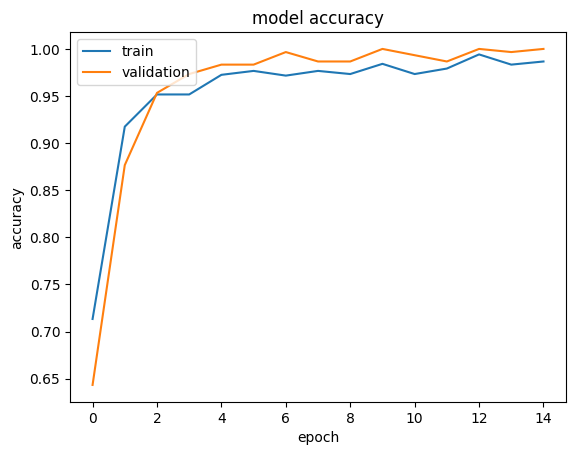

In [21]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [22]:
# Cell 9: Unfreeze model and continue training
for layer in model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 5
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/5
75/75 [==============================] - 268s 3s/step - loss: 0.1857 - accuracy: 0.9892 - val_loss: 0.1525 - val_accuracy: 1.0000
Epoch 2/5
75/75 [==============================] - 284s 4s/step - loss: 0.1707 - accuracy: 0.9917 - val_loss: 0.1446 - val_accuracy: 1.0000
Epoch 3/5
75/75 [==============================] - 280s 4s/step - loss: 0.1705 - accuracy: 0.9933 - val_loss: 0.1440 - val_accuracy: 1.0000
Epoch 4/5
75/75 [==============================] - 277s 4s/step - loss: 0.1664 - accuracy: 0.9925 - val_loss: 0.1496 - val_accuracy: 1.0000
Epoch 5/5
75/75 [==============================] - 249s 3s/step - loss: 0.1661 - accuracy: 0.9933 - val_loss: 0.1417 - val_accuracy: 1.0000


In [23]:
# Cell 10: Save the model
model.save('/content/drive/MyDrive/Colab Notebooks/ConvNeXt-XL.h5')


(1.0, 5.0)

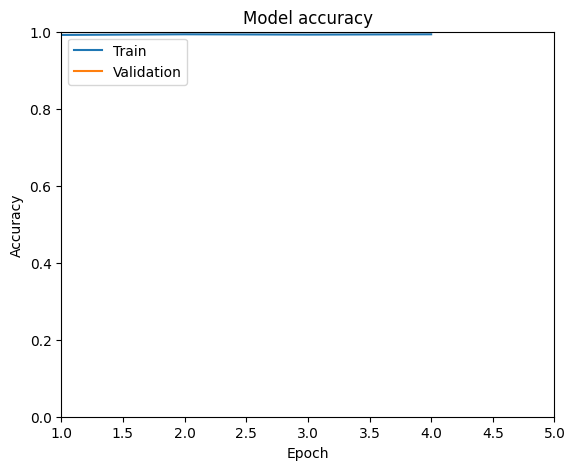

In [24]:
# Cell 11: Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim([0, 1])  # Set the y-axis scale from 0 to 1
plt.xlim([1, epochs])  # Set the x-axis scale from 1 to number of epochs


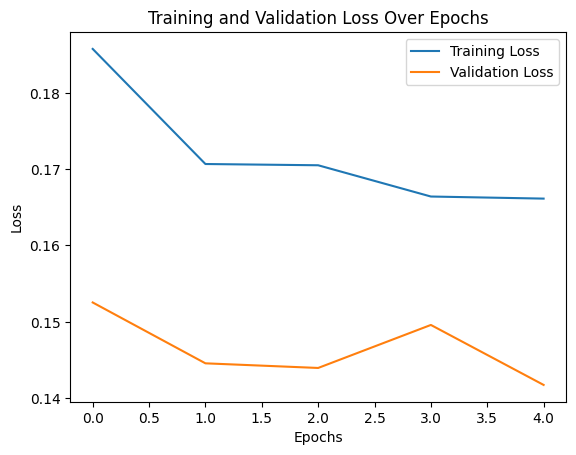

In [25]:

plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
